# MT3DMS Multiple Species

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import datetime
import math
from sklearn.metrics import mean_squared_error as mse
import flopy.mt3d as mt3
from flopy.export import vtk
import itertools as it
%matplotlib inline

In [2]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.7 (v3.6.7:6ec5cf24b7, Oct 20 2018, 13:35:33) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
pandas version: 0.23.4
matplotlib version: 3.0.2
flopy version: 3.2.10


In [3]:
exe_name_mf = 'mf2005.exe'
exe_name_mt = 'mt3dms5b.exe'
workspace = os.path.join('.', 'multi-species')
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

In [4]:
tm = mf.Modflow(modelname='test', exe_name=exe_name_mf, version='mf2005', model_ws=workspace)

In [5]:
Lx = 1000
Ly = 1000
top = 50
botm = 0
nlay = 1
nrow = 10
ncol = 10
delr = Lx/ncol
delc = Ly/nrow
delv = (top - botm) / nlay


#steady = np.full ( 10, False, dtype=bool )
steady = True

dis = flopy.modflow.ModflowDis(tm, nlay, nrow, ncol, delr=delr, delc=delc, nper =1 ,perlen = 3000, steady = steady,
                               top=top, botm=botm)

In [6]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.
strt[:, :, -1] = 0.
bas = flopy.modflow.ModflowBas(tm, ibound=ibound, strt=strt)

In [7]:
wel = flopy.modflow.ModflowWel(tm, stress_period_data={0:[0, 5, 5, 1]})
lpf = flopy.modflow.ModflowLpf(tm, hk=10., vka=10., ipakcb=53)
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(tm, stress_period_data=spd, compact=True)
lmt = flopy.modflow.ModflowLmt(tm)
pcg = flopy.modflow.ModflowPcg(tm)
tm.write_input()
success, buff = tm.run_model()

FloPy is using the following  executable to run the model: C:\modflow\Packages\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: test.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/01/09 17:51:54

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/01/09 17:51:54
 Elapsed run time:  0.124 Seconds

  Normal termination of simulation


In [8]:
mt = flopy.mt3d.Mt3dms(modelname='test', model_ws=workspace, 
                           exe_name=exe_name_mt, modflowmodel=tm)

In [9]:
adv = mt3.Mt3dAdv(mt, mixelm = -1, percel = 0.75)
icbund = np.ones((nlay, nrow, ncol), dtype=np.int32)
icbund[:,:,0] = -1
icbund[:,:,-1] = -1

sconc_1 = np.ones((nlay, nrow, ncol)) * 0 
sconc_2 = np.ones((nlay, nrow, ncol)) * 0 


btn = mt3.Mt3dBtn(mt,icbund= icbund, ncomp=2, mcomp=2,sconc = sconc_1, sconc2 = sconc_2, prsity = 0.3) #mcomp should be changed for multiple species

dsp = mt3.Mt3dDsp(mt, al = 10, trpt= 0.1,trpv = 0.03, dmcoef= 0.13, dmcoef2 = 0.2)

gcg = mt3.Mt3dGcg(mt, mxiter=1,iter1=50,isolve = 2,cclose = 1e-2,ncrs =1)             
rct = mt3.Mt3dRct(mt,isothm=1,ireact=0, prsity2= 0.3, igetsc=0, rhob = 1.87e3, sp1= 1.8e-4, sp12= 5.8e-4)

itype = flopy.mt3d.Mt3dSsm.itype_dict()

spd = {0:[0, 5, 5, 1000, itype['WEL'] , 1000, 10]}
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)

mt.write_input()
mt.run_model(#silent = True
                )
fname = os.path.join(workspace, 'MT3D001.UCN')
fname1 = os.path.join(workspace, 'MT3D002.UCN')
ucnobj = flopy.utils.UcnFile(fname)
ucnobj1 = flopy.utils.UcnFile(fname1)
times = ucnobj.get_times()
conc = ucnobj.get_alldata()
times1 = ucnobj1.get_times()
conc1 = ucnobj1.get_alldata()

RCT: setting srconc for component 2 to zero, kwarg name srconc2
RCT: setting sp2 for component 2 to zero, kwarg name sp22
RCT: setting rc1 for component 2 to zero, kwarg name rc12
RCT: setting rc2 for component 2 to zero, kwarg name rc22
FloPy is using the following  executable to run the model: C:\modflow\Packages\mt3dms5b.exe
MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
Developed at University of Alabama for U.S. Department of Defense

Using NAME File: test.nam                                          

STRESS PERIOD NO.    1

TIME STEP NO.    1
FROM TIME =   0.0000     TO    3000.0    

Transport Step:    1   Step Size:   429.3     Total Elapsed Time:   429.31    
Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.158      [K,I,J]    1    6    6
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6791E-03  [K,I,J]    1    5    7
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5751E-02  [K,I,J]    1    6    6
Transport Step:    2   Step Size:   429.3     Total Elapsed Time: 

#### Plot for species 1

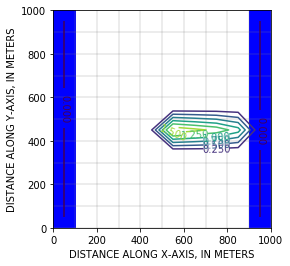

In [10]:
mm = flopy.plot.ModelMap(model=tm)
mm.plot_grid(color='.5', alpha=0.2)
mm.plot_ibound()
cs = mm.contour_array(conc[0])
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.show()

#### Plot for species 2

Text(0, 0.5, 'DISTANCE ALONG Y-AXIS, IN METERS')

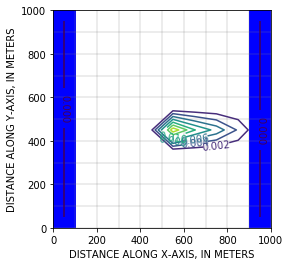

In [11]:
mm = flopy.plot.ModelMap(model=tm)
mm.plot_grid(color='.5', alpha=0.2)
mm.plot_ibound()
cs = mm.contour_array(conc1[0])
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')